# Text Generation
Generating text with an n-gram language model

Author: Pierre Nugues

## Reading a Corpus
Utility function to read all the files in a folder

In [1]:
import os
from collections import Counter


def get_files(dir, suffix):
    """
    Returns all the files in a folder ending with suffix
    :param dir:
    :param suffix:
    :return: the list of file names
    """
    files = []
    for file in os.listdir(dir):
        if file.endswith(suffix):
            files.append(file)
    return files

## Tokenizer
An elemetary tokenizer

In [2]:
import regex as re


def tokenize(text):
    """
    Uses the letters to break the text into words.
    Returns a list of match objects
    """
    words = re.findall('\p{L}+', text)
    return words

## Reading the Files
We read a corpus of novels from Dickens or Lagerlöf

In [3]:
corpus = 'Iliad'

In [4]:
if corpus == 'Selma':
    folder = '/Users/pierre/Documents/Cours/EDAN20/corpus/Selma/'
elif corpus == 'Dickens':
    folder = '/Users/pierre/Documents/Cours/EDAN20/corpus/Dickens/'
elif corpus == 'Iliad':
    folder = '/Users/pierre/Documents/Cours/EDAN20/programs/corpus/Classics/'

if corpus == 'Selma' or corpus == 'Dickens':
    files = get_files(folder, 'txt')
else:
    files = ['iliad.mb.txt']
files

['iliad.mb.txt']

We tokenize the texts

In [5]:
words = []
for file in files:
    text = open(folder + file).read().lower().strip()
    if corpus == 'Iliad':  # We remove the copyright
        text = re.search(r'^-+$(.+)^-+$',
                         text, re.M | re.S).group(1).strip()
    words += tokenize(text)

words[:10]

['book', 'i', 'sing', 'o', 'goddess', 'the', 'anger', 'of', 'achilles', 'son']

## N-gram functions

### We count the unigrams and bigrams

In [6]:
word_freqs = Counter(words)

In [7]:
if corpus == 'Selma':
    print(word_freqs['nils'])
elif corpus == 'Dickens':
    print(word_freqs['oliver'])
elif corpus == 'Iliad':
    print(word_freqs['hector'])

480


In [8]:
bigrams = [tuple(words[idx:idx + 2])
           for idx in range(len(words) - 1)]
bigram_freqs = Counter(bigrams)

## Conditional Probabilities

Given a bigram, $w_n, w_{n+1}$, we compute $P(w_{n+1}|w_n)$. This is defined as $\frac{count(w_n, w_{n+1})}{count(w_n)}$.

In [9]:
cond_probs = {k: v/word_freqs[k[0]] for
              k, v in bigram_freqs.items()}

### Extracting the conditional probabilities of a word

In [10]:
def bigram_dist(word, cond_probs):
    bigram_cprobs = sorted(
        [(k, v) for k, v in cond_probs.items() 
         if k[0] == word],
        key=lambda tup: tup[1], reverse=True)
    return bigram_cprobs

In [11]:
if corpus == 'Selma':
    print(bigram_dist('nils', cond_probs))
elif corpus == 'Dickens':
    print(bigram_dist('oliver', cond_probs))
elif corpus == 'Iliad':
    print(bigram_dist('hector', cond_probs))

[(('hector', 'and'), 0.11666666666666667), (('hector', 'son'), 0.052083333333333336), (('hector', 's'), 0.04791666666666667), (('hector', 'was'), 0.03125), (('hector', 'in'), 0.022916666666666665), (('hector', 'who'), 0.022916666666666665), (('hector', 'for'), 0.020833333333333332), (('hector', 'as'), 0.020833333333333332), (('hector', 'said'), 0.016666666666666666), (('hector', 'saw'), 0.016666666666666666), (('hector', 'you'), 0.014583333333333334), (('hector', 'had'), 0.014583333333333334), (('hector', 'to'), 0.014583333333333334), (('hector', 'then'), 0.014583333333333334), (('hector', 'when'), 0.014583333333333334), (('hector', 'with'), 0.014583333333333334), (('hector', 'is'), 0.014583333333333334), (('hector', 'answered'), 0.0125), (('hector', 'the'), 0.0125), (('hector', 'at'), 0.0125), (('hector', 'now'), 0.010416666666666666), (('hector', 'on'), 0.010416666666666666), (('hector', 'has'), 0.010416666666666666), (('hector', 'from'), 0.010416666666666666), (('hector', 'sprang'),

### Drawing samples from a multinomial distribution. 

Understanding the `np.random.multinomial` function

In [12]:
import numpy as np
np.random.seed(0)
for i in range(10):
    print(np.random.multinomial(1, [0.3, 0.5, 0.2]))

[0 0 1]
[0 1 0]
[0 1 0]
[0 0 1]
[1 0 0]
[0 0 1]
[0 1 0]
[1 0 0]
[0 1 0]
[0 0 1]


On a large number of draws

In [13]:
np.random.multinomial(100000, [0.3, 0.5, 0.2])

array([30330, 49807, 19863])

### And finally, generating a sequence

In [14]:
if corpus == 'Selma':
    start_word = 'nils'
elif corpus == 'Dickens':
    start_word = 'oliver'
elif corpus == 'Iliad':
    start_word = 'hector'

In [15]:
print(start_word, end=' ')
current_word = start_word
for i in range(50):
    bigram_cprobs = bigram_dist(current_word, cond_probs)
    dist = [bigram_cprob[1] for bigram_cprob in bigram_cprobs]
    selected_idx = np.argmax(np.random.multinomial(1, dist))
    next_bigram_cprob = bigram_cprobs[selected_idx]
    current_word = next_bigram_cprob[0][1]
    print(current_word, end=' ')

hector they built round the company while iris left the roots of oileus commanded by the waves of fear and brave son of menoetius gave it but waves of hippasus and the hill and not wait then stripped the spear into the other for i slay him glaucus son of the 

## Reweighting Distributions
We will now reweight the distribution of the second word in the bigram to make the generation more reproducible or more random

In [16]:
start_bigrams = bigram_dist(start_word, cond_probs)
start_bigrams

[(('hector', 'and'), 0.11666666666666667),
 (('hector', 'son'), 0.052083333333333336),
 (('hector', 's'), 0.04791666666666667),
 (('hector', 'was'), 0.03125),
 (('hector', 'in'), 0.022916666666666665),
 (('hector', 'who'), 0.022916666666666665),
 (('hector', 'for'), 0.020833333333333332),
 (('hector', 'as'), 0.020833333333333332),
 (('hector', 'said'), 0.016666666666666666),
 (('hector', 'saw'), 0.016666666666666666),
 (('hector', 'you'), 0.014583333333333334),
 (('hector', 'had'), 0.014583333333333334),
 (('hector', 'to'), 0.014583333333333334),
 (('hector', 'then'), 0.014583333333333334),
 (('hector', 'when'), 0.014583333333333334),
 (('hector', 'with'), 0.014583333333333334),
 (('hector', 'is'), 0.014583333333333334),
 (('hector', 'answered'), 0.0125),
 (('hector', 'the'), 0.0125),
 (('hector', 'at'), 0.0125),
 (('hector', 'now'), 0.010416666666666666),
 (('hector', 'on'), 0.010416666666666666),
 (('hector', 'has'), 0.010416666666666666),
 (('hector', 'from'), 0.010416666666666666),

In [17]:
len(start_bigrams)

184

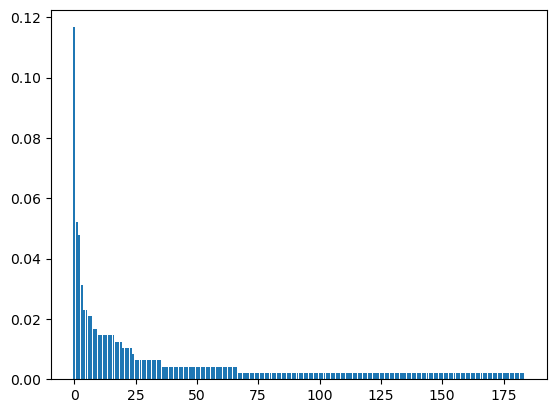

In [18]:
import matplotlib.pyplot as plt

freqs = [bigram[1] for bigram in start_bigrams]
plt.bar(range(len(freqs)), freqs)
plt.show()

### The Temperature
We reweight the distribution over the next word with a temperature following Chollet (2021), _Deep Learning with Python_, 2nd ed., pp. 369 and 373.

Chollet defines the temperature as
$$
    \exp(\frac{\log(x)}{temp}) = x^{\frac{1}{temp}}
$$

In [19]:
def power_transform(distribution, T=0.5):
    new_dist = np.power(distribution, 1/T)
    return new_dist / np.sum(new_dist)

In [20]:
# Chollet original
"""def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)"""

'def reweight_distribution(original_distribution, temperature=0.5):\n    distribution = np.log(original_distribution) / temperature\n    distribution = np.exp(distribution)\n    return distribution / np.sum(distribution)'

In [21]:
freqs

[0.11666666666666667,
 0.052083333333333336,
 0.04791666666666667,
 0.03125,
 0.022916666666666665,
 0.022916666666666665,
 0.020833333333333332,
 0.020833333333333332,
 0.016666666666666666,
 0.016666666666666666,
 0.014583333333333334,
 0.014583333333333334,
 0.014583333333333334,
 0.014583333333333334,
 0.014583333333333334,
 0.014583333333333334,
 0.014583333333333334,
 0.0125,
 0.0125,
 0.0125,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.008333333333333333,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.00625,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.004166666666666667,
 0.0

Low temperatures: more deterministic. We freeze the generation

In [22]:
low_temp_freqs = power_transform(freqs, T=0.5)
low_temp_freqs

array([5.23364486e-01, 1.04305741e-01, 8.82843792e-02, 3.75500668e-02,
       2.01935915e-02, 2.01935915e-02, 1.66889186e-02, 1.66889186e-02,
       1.06809079e-02, 1.06809079e-02, 8.17757009e-03, 8.17757009e-03,
       8.17757009e-03, 8.17757009e-03, 8.17757009e-03, 8.17757009e-03,
       8.17757009e-03, 6.00801068e-03, 6.00801068e-03, 6.00801068e-03,
       4.17222964e-03, 4.17222964e-03, 4.17222964e-03, 4.17222964e-03,
       2.67022697e-03, 1.50200267e-03, 1.50200267e-03, 1.50200267e-03,
       1.50200267e-03, 1.50200267e-03, 1.50200267e-03, 1.50200267e-03,
       1.50200267e-03, 1.50200267e-03, 1.50200267e-03, 1.50200267e-03,
       6.67556742e-04, 6.67556742e-04, 6.67556742e-04, 6.67556742e-04,
       6.67556742e-04, 6.67556742e-04, 6.67556742e-04, 6.67556742e-04,
       6.67556742e-04, 6.67556742e-04, 6.67556742e-04, 6.67556742e-04,
       6.67556742e-04, 6.67556742e-04, 6.67556742e-04, 6.67556742e-04,
       6.67556742e-04, 6.67556742e-04, 6.67556742e-04, 6.67556742e-04,
      

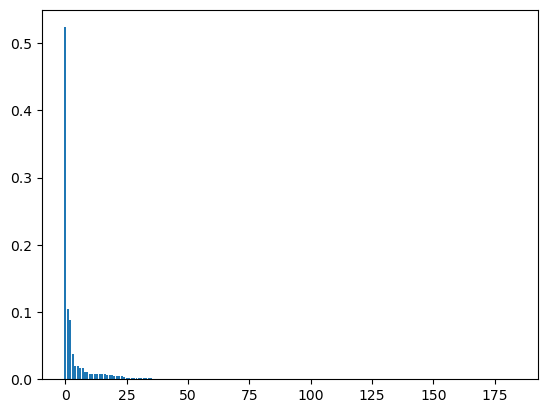

In [23]:
plt.bar(range(len(low_temp_freqs)), low_temp_freqs)
plt.show()

High temperatures: More randomness

In [24]:
high_temp_freqs = power_transform(freqs, T=5.0)

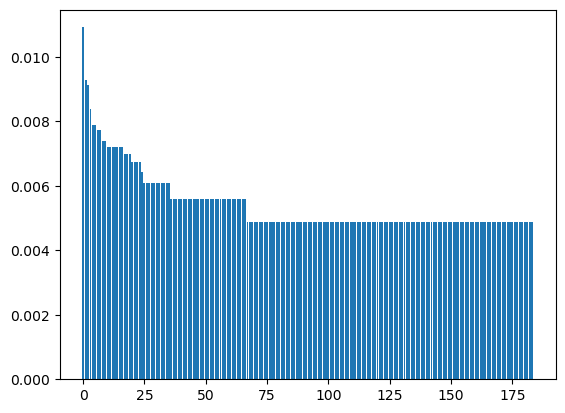

In [25]:
plt.bar(range(len(high_temp_freqs)), high_temp_freqs)
plt.show()

In [26]:
temperature = 0.5

In [27]:
print(start_word, end=' ')
current_word = start_word
for i in range(50):
    bigram_cprobs = bigram_dist(current_word, cond_probs)
    dist = [bigram_cprob[1] for bigram_cprob in bigram_cprobs]
    dist = power_transform(dist, temperature)
    selected_idx = np.argmax(np.random.multinomial(1, dist))
    next_bigram_cprob = bigram_cprobs[selected_idx]
    current_word = next_bigram_cprob[0][1]
    print(current_word, end=' ')

hector and he was lying dream went up to the achaeans will be bought nor of the shield of his father jove in the trojans and the son of the achaeans and the argives and the trojans and the body of the achaeans if you are you have been dearest to 